In [ ]:
import torch
import math
import matplotlib.pyplot as plt
torch.set_printoptions(profile="full")


In [ ]:
#physical Constants
F = 96485.332 #C/mol - Faraday constant
T = 298 #K - Temperature
R = 8.314 #J/mol-K - Gas const.
Beta = 0.5 #grid expansion factor 0 < BT < 1

#reaction Constants
DR = 5.56e-9 #m^2/s - Diffusion coeff of reactant R
DP = 5.56e-9 #m^2/s - Diffusion coeff of reactant P
kf = 1e-9 #m^2/s - Surface rate constant (max value ~ 1 m^2/s)
kb = 1e-9 #m^2/s - Surface rate constant (max value ~ 1 m^2/s)
E0 = 0.8 #V - True reversible potential
Alpha = 0.5 #Transfer coefficient
n = 1 # # of electrons transferred
VT = Alpha*n*F/(R*T) #V -mod. thermal voltage for n = 1
Ncycle = 3 #number of CV cycles


#experiment constants
nu = 1 #V/s- Sweep rate
Ei = 0.6 #V - initial voltage
Emax = 1.5 #V - Max voltage (end for forwards sweep
Emin = 0.1 #V - Min voltage (end for backwards sweep)
dE = 0.001 #V - potential step
CR0 = 0.001 #M - bulk conc. of reactant R - MUST have a decimal!
CP0 = 0 #M - bulk conc. of product P


In [ ]:
dt = 0.001
dx = 7.021045531185578e-10
Ds = max([DR, DP]) * dt / (dx * dx)
print("Ds =", Ds)

tf = (Emax-Emin) / nu #s, timescale of experiment operation
xmax = 6.0*math.sqrt(max([DR,DP])*tf) #maximum diffusion distance
N = 1 + math.ceil(math.log(1 + (xmax*(math.exp(Beta) - 1)/dx) )/Beta)  #+1 for ghost pt

print("N =", N)
print("xmax =", xmax)

Ds = 11279016.0
N = 28
xmax = 0.0005293618800027067


In [ ]:
tf = (Emax-Emin) / nu #s, timescale of experiment operation
dt = dE / nu #s, timestep

kValues = torch.tensor([kf * math.exp(VT * (Emin-E0)), kb * math.exp(VT * (Emax-E0))])

Ds = R * T * max(kValues) / (F * nu) #Target dimensionless diffusion coeff

rat = (dE/0.001)*Ds/max([DR,DP]) #ratio of dt/(dx)^2
dx = math.sqrt(dt/rat) #Necesary 'base' x-spacing for accuracy

xmax = 6.0*math.sqrt(max([DR,DP])*tf) #maximum diffusion distance
N = 1 + math.ceil(math.log(1 + (xmax*(math.exp(Beta) - 1)/dx) )/Beta)  #+1 for ghost pt

print(N)

4


In [ ]:
#create the array of space
x = torch.empty(2+2*N, 1, dtype = torch.float)
x[0] = 0
for k in range(1, 1+N):
  x[k] = dx * (math.exp(Beta*(k-0.5))-1) / (math.exp(Beta)-1)
for k in range(1+N, 2*N+2):
  x[k] = x[k-N-1]

dx1 = dx * (math.exp(Beta/2)-1)/(math.exp(Beta)-1)

In [ ]:
#create tensors for the diffusion coefficients
D1 = torch.empty(N, 1, dtype = torch.float)
D2 = torch.empty(N, 1, dtype = torch.float)
D3 = torch.empty(N, 1, dtype = torch.float)

#set values for the diffusion coefficients
D1[0] = Ds * (math.exp(Beta)-1) / (math.exp(Beta/2) - 1)
D2[0] = Ds * math.exp(2*Beta*(3/4 - 1))
D3[0] = D1[0] + D2[0] + 1

for k in range(1, N):
  D1[k] = Ds * math.exp(2 * Beta * (5/4 - k - 1))
  D2[k] = Ds * math.exp(2 * Beta * (3/4 - k - 1))
  D3[k] = D1[k] + D2[k] + 1


In [ ]:
#create a tensor size (2N+2)*(2N+2) with uninitialized memory
Dopt = torch.empty(2*N+2, 2*N+2, dtype=torch.float).fill_(0)
Drat = DR/DP

#set values for the operator Dopt

#set values for row 0
Dopt[0, 0] = math.exp(n * F * (Ei - E0) / (R * T))
Dopt[0, N+1] = -1
for j in range(1, N+1):
  Dopt[0, j] = 0
for j in range(N+2, 2*N+2):
  Dopt[0, j] = 0

#set values for row N+1
Dopt[N+1, 0] = -Drat
Dopt[N+1, 1] = Drat
Dopt[N+1, N+1] = -1
Dopt[N+1, N+2] = 1
for j in range(2, N+1):
  Dopt[N+1, j] = 0
for j in range(N+3, 2*N+2):
  Dopt[N+1, j] = 0

#set values for row N
Dopt[N, N] = 1
for j in range(0, N):
  Dopt[N, j] = 0
for j in range(N+1, 2*N+2):
  Dopt[N, j] = 0

#set values for row 2N+1
Dopt[2*N+1, 2*N+1] = 1
for j in range(N+1, 2*N+1):
  Dopt[2*N+1, j] = 0


In [ ]:
#set values for other rows for Dopt
for i in range(1, N):
  Dopt[i, i] = D3[i-1]
  Dopt[i, i-1] = -D1[i-1]
  Dopt[i, i+1] = -D2[i-1]
  for j in range(0, i-1):
    Dopt[i, j] = 0
  for j in range(i+2, 2*N+2):
    Dopt[i, j] = 0

for i in range(N+2, 2*N+1):
  Dopt[i, i] = D3[i-N-2]
  Dopt[i, i-1] = -D1[i-N-2]
  Dopt[i, i+1] = -D2[i-N-2]
  for j in range(0, i-1):
    Dopt[i, j] = 0
  for j in range(i+2, 2*N+2):
    Dopt[i, j] = 0


In [ ]:
#create tensors for the new concentration
Cnew = torch.empty(2*N+2, 1, dtype = torch.float)
for i in range(1, N+1):
  Cnew[i] = CR0
for i in range(N+1, 2*N+2):
  Cnew[i] = CP0

#create tensors for the old concentration
Cold = torch.empty(2*N+2, 1, dtype = torch.float)
for i in range(1, N+1):
  Cold[i] = CR0
for i in range(N+1, 2*N+2):
  Cold[i] = CP0

Cold[0] = 0
Cold[N+1] = 0

In [ ]:
#Initialize potential vector

Evt = torch.cat([torch.arange((Ei+dE),(Emax+dE),dE), torch.arange(Emax,(Emin-dE),-dE), torch.arange(Emin, (Ei+2*dE), dE)])

Evt = Evt.reshape(len(Evt),1)
print(Evt.shape)
Istor = 0.0*Evt
count = 0

#print(Evt)

torch.Size([2803, 1])


tensor([0.6010]) 1e-09 1e-09 tensor([0.0010]) tensor([0.])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


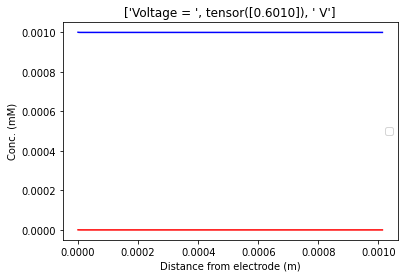

0 tensor([0.6010])
tensor([0.6020]) 1e-09 1e-09 tensor([0.0010]) tensor([0.])
tensor([0.6030]) 1e-09 1e-09 tensor([0.0010]) tensor([0.])
tensor([0.6040]) 1e-09 1e-09 tensor([0.0010]) tensor([0.0002])
tensor([0.6050]) 1e-09 1e-09 tensor([0.0010]) tensor([0.])
tensor([0.6060]) 1e-09 1e-09 tensor([0.0010]) tensor([0.])
tensor([0.6070]) 1e-09 1e-09 tensor([0.0010]) tensor([0.])
tensor([0.6080]) 1e-09 1e-09 tensor([0.0010]) tensor([0.])
tensor([0.6090]) 1e-09 1e-09 tensor([0.0010]) tensor([0.])
tensor([0.6100]) 1e-09 1e-09 tensor([0.0010]) tensor([0.])
tensor([0.6110]) 1e-09 1e-09 tensor([0.0010]) tensor([0.])
tensor([0.6120]) 1e-09 1e-09 tensor([0.0010]) tensor([0.])
tensor([0.6130]) 1e-09 1e-09 tensor([0.0010]) tensor([0.])
tensor([0.6140]) 1e-09 1e-09 tensor([0.0010]) tensor([0.])
tensor([0.6150]) 1e-09 1e-09 tensor([0.0010]) tensor([0.0002])
tensor([0.6160]) 1e-09 1e-09 tensor([0.0010]) tensor([0.])
tensor([0.6170]) 1e-09 1e-09 tensor([0.0010]) tensor([0.])
tensor([0.6180]) 1e-09 1e-09 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


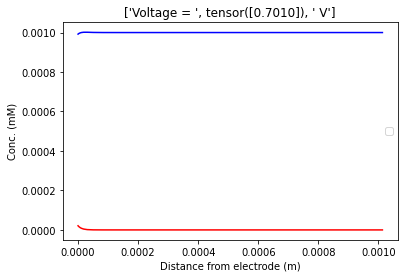

100 tensor([0.7010])
tensor([0.7020]) 1e-09 1e-09 tensor([0.0010]) tensor([0.0010])
tensor([0.7030]) 1e-09 1e-09 tensor([0.0010]) tensor([0.0010])
tensor([0.7040]) 1e-09 1e-09 tensor([0.0010]) tensor([0.0010])
tensor([0.7050]) 1e-09 1e-09 tensor([0.0010]) tensor([0.0012])
tensor([0.7060]) 1e-09 1e-09 tensor([0.0010]) tensor([0.0010])
tensor([0.7070]) 1e-09 1e-09 tensor([0.0010]) tensor([0.0012])
tensor([0.7080]) 1e-09 1e-09 tensor([0.0010]) tensor([0.0012])
tensor([0.7090]) 1e-09 1e-09 tensor([0.0010]) tensor([0.0012])
tensor([0.7100]) 1e-09 1e-09 tensor([0.0010]) tensor([0.0012])
tensor([0.7110]) 1e-09 1e-09 tensor([0.0010]) tensor([0.0014])
tensor([0.7120]) 1e-09 1e-09 tensor([0.0010]) tensor([0.0014])
tensor([0.7130]) 1e-09 1e-09 tensor([0.0010]) tensor([0.0016])
tensor([0.7140]) 1e-09 1e-09 tensor([0.0010]) tensor([0.0014])
tensor([0.7150]) 1e-09 1e-09 tensor([0.0010]) tensor([0.0014])
tensor([0.7160]) 1e-09 1e-09 tensor([0.0010]) tensor([0.0016])
tensor([0.7170]) 1e-09 1e-09 tenso

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


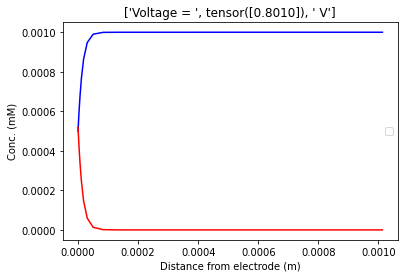

200 tensor([0.8010])
tensor([0.8020]) 1e-09 1e-09 tensor([0.0005]) tensor([0.0177])
tensor([0.8030]) 1e-09 1e-09 tensor([0.0005]) tensor([0.0178])
tensor([0.8040]) 1e-09 1e-09 tensor([0.0005]) tensor([0.0180])
tensor([0.8050]) 1e-09 1e-09 tensor([0.0005]) tensor([0.0182])
tensor([0.8060]) 1e-09 1e-09 tensor([0.0005]) tensor([0.0183])
tensor([0.8070]) 1e-09 1e-09 tensor([0.0004]) tensor([0.0184])
tensor([0.8080]) 1e-09 1e-09 tensor([0.0004]) tensor([0.0188])
tensor([0.8090]) 1e-09 1e-09 tensor([0.0004]) tensor([0.0189])
tensor([0.8100]) 1e-09 1e-09 tensor([0.0004]) tensor([0.0190])
tensor([0.8110]) 1e-09 1e-09 tensor([0.0004]) tensor([0.0191])
tensor([0.8120]) 1e-09 1e-09 tensor([0.0004]) tensor([0.0192])
tensor([0.8130]) 1e-09 1e-09 tensor([0.0004]) tensor([0.0194])
tensor([0.8140]) 1e-09 1e-09 tensor([0.0004]) tensor([0.0195])
tensor([0.8150]) 1e-09 1e-09 tensor([0.0004]) tensor([0.0197])
tensor([0.8160]) 1e-09 1e-09 tensor([0.0004]) tensor([0.0197])
tensor([0.8170]) 1e-09 1e-09 tenso

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


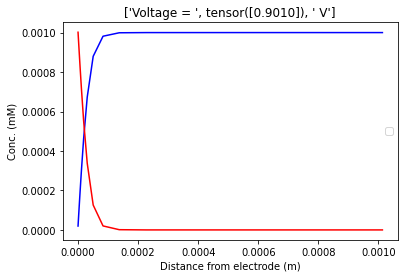

300 tensor([0.9010])
tensor([0.9020]) 1e-09 1e-09 tensor([1.8878e-05]) tensor([0.0140])
tensor([0.9030]) 1e-09 1e-09 tensor([1.8170e-05]) tensor([0.0139])
tensor([0.9040]) 1e-09 1e-09 tensor([1.7493e-05]) tensor([0.0138])
tensor([0.9050]) 1e-09 1e-09 tensor([1.6850e-05]) tensor([0.0137])
tensor([0.9060]) 1e-09 1e-09 tensor([1.6224e-05]) tensor([0.0137])
tensor([0.9070]) 1e-09 1e-09 tensor([1.5612e-05]) tensor([0.0136])
tensor([0.9080]) 1e-09 1e-09 tensor([1.5016e-05]) tensor([0.0135])
tensor([0.9090]) 1e-09 1e-09 tensor([1.4449e-05]) tensor([0.0134])
tensor([0.9100]) 1e-09 1e-09 tensor([1.3904e-05]) tensor([0.0134])
tensor([0.9110]) 1e-09 1e-09 tensor([1.3388e-05]) tensor([0.0133])
tensor([0.9120]) 1e-09 1e-09 tensor([1.2880e-05]) tensor([0.0132])
tensor([0.9130]) 1e-09 1e-09 tensor([1.2401e-05]) tensor([0.0132])
tensor([0.9140]) 1e-09 1e-09 tensor([1.1940e-05]) tensor([0.0131])
tensor([0.9150]) 1e-09 1e-09 tensor([1.1489e-05]) tensor([0.0130])
tensor([0.9160]) 1e-09 1e-09 tensor([1.10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


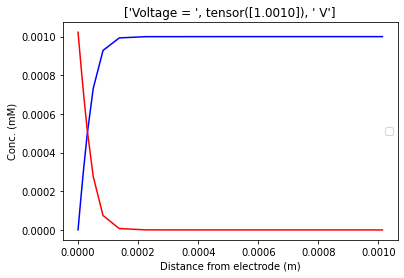

400 tensor([1.0010])
tensor([1.0020]) 1e-09 1e-09 tensor([3.9205e-07]) tensor([0.0093])
tensor([1.0030]) 1e-09 1e-09 tensor([3.7707e-07]) tensor([0.0093])
tensor([1.0040]) 1e-09 1e-09 tensor([3.6294e-07]) tensor([0.0093])
tensor([1.0050]) 1e-09 1e-09 tensor([3.4921e-07]) tensor([0.0092])
tensor([1.0060]) 1e-09 1e-09 tensor([3.3598e-07]) tensor([0.0092])
tensor([1.0070]) 1e-09 1e-09 tensor([3.2324e-07]) tensor([0.0092])
tensor([1.0080]) 1e-09 1e-09 tensor([3.1089e-07]) tensor([0.0092])
tensor([1.0090]) 1e-09 1e-09 tensor([2.9910e-07]) tensor([0.0091])
tensor([1.0100]) 1e-09 1e-09 tensor([2.8768e-07]) tensor([0.0091])
tensor([1.0110]) 1e-09 1e-09 tensor([2.7673e-07]) tensor([0.0091])
tensor([1.0120]) 1e-09 1e-09 tensor([2.6621e-07]) tensor([0.0091])
tensor([1.0130]) 1e-09 1e-09 tensor([2.5608e-07]) tensor([0.0090])
tensor([1.0140]) 1e-09 1e-09 tensor([2.4634e-07]) tensor([0.0090])
tensor([1.0150]) 1e-09 1e-09 tensor([2.3694e-07]) tensor([0.0090])
tensor([1.0160]) 1e-09 1e-09 tensor([2.27

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


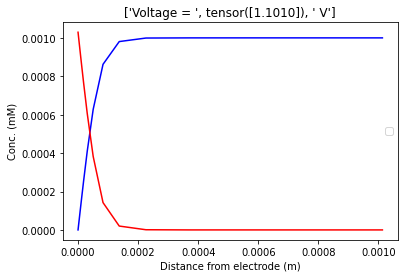

500 tensor([1.1010])
tensor([1.1020]) 1e-09 1e-09 tensor([8.0323e-09]) tensor([0.0075])
tensor([1.1030]) 1e-09 1e-09 tensor([7.7260e-09]) tensor([0.0075])
tensor([1.1040]) 1e-09 1e-09 tensor([7.4305e-09]) tensor([0.0075])
tensor([1.1050]) 1e-09 1e-09 tensor([7.1475e-09]) tensor([0.0074])
tensor([1.1060]) 1e-09 1e-09 tensor([6.8740e-09]) tensor([0.0074])
tensor([1.1070]) 1e-09 1e-09 tensor([6.6115e-09]) tensor([0.0074])
tensor([1.1080]) 1e-09 1e-09 tensor([6.3590e-09]) tensor([0.0074])
tensor([1.1090]) 1e-09 1e-09 tensor([6.1167e-09]) tensor([0.0074])
tensor([1.1100]) 1e-09 1e-09 tensor([5.8834e-09]) tensor([0.0074])
tensor([1.1110]) 1e-09 1e-09 tensor([5.6584e-09]) tensor([0.0074])
tensor([1.1120]) 1e-09 1e-09 tensor([5.4425e-09]) tensor([0.0074])
tensor([1.1130]) 1e-09 1e-09 tensor([5.2349e-09]) tensor([0.0073])
tensor([1.1140]) 1e-09 1e-09 tensor([5.0349e-09]) tensor([0.0073])
tensor([1.1150]) 1e-09 1e-09 tensor([4.8432e-09]) tensor([0.0073])
tensor([1.1160]) 1e-09 1e-09 tensor([4.65

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


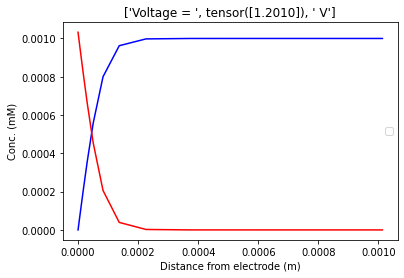

600 tensor([1.2010])
tensor([1.2020]) 1e-09 1e-09 tensor([1.6403e-10]) tensor([0.0065])
tensor([1.2030]) 1e-09 1e-09 tensor([1.5776e-10]) tensor([0.0064])
tensor([1.2040]) 1e-09 1e-09 tensor([1.5174e-10]) tensor([0.0064])
tensor([1.2050]) 1e-09 1e-09 tensor([1.4596e-10]) tensor([0.0064])
tensor([1.2060]) 1e-09 1e-09 tensor([1.4039e-10]) tensor([0.0064])
tensor([1.2070]) 1e-09 1e-09 tensor([1.3502e-10]) tensor([0.0064])
tensor([1.2080]) 1e-09 1e-09 tensor([1.2987e-10]) tensor([0.0064])
tensor([1.2090]) 1e-09 1e-09 tensor([1.2492e-10]) tensor([0.0064])
tensor([1.2100]) 1e-09 1e-09 tensor([1.2014e-10]) tensor([0.0064])
tensor([1.2110]) 1e-09 1e-09 tensor([1.1555e-10]) tensor([0.0064])
tensor([1.2120]) 1e-09 1e-09 tensor([1.1114e-10]) tensor([0.0064])
tensor([1.2130]) 1e-09 1e-09 tensor([1.0691e-10]) tensor([0.0064])
tensor([1.2140]) 1e-09 1e-09 tensor([1.0283e-10]) tensor([0.0064])
tensor([1.2150]) 1e-09 1e-09 tensor([9.8914e-11]) tensor([0.0063])
tensor([1.2160]) 1e-09 1e-09 tensor([9.51

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


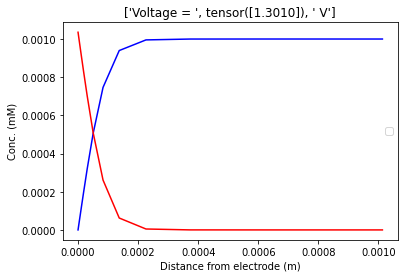

700 tensor([1.3010])
tensor([1.3020]) 1e-09 1e-09 tensor([3.3485e-12]) tensor([0.0058])
tensor([1.3030]) 1e-09 1e-09 tensor([3.2208e-12]) tensor([0.0058])
tensor([1.3040]) 1e-09 1e-09 tensor([3.0977e-12]) tensor([0.0058])
tensor([1.3050]) 1e-09 1e-09 tensor([2.9793e-12]) tensor([0.0057])
tensor([1.3060]) 1e-09 1e-09 tensor([2.8655e-12]) tensor([0.0057])
tensor([1.3070]) 1e-09 1e-09 tensor([2.7562e-12]) tensor([0.0057])
tensor([1.3080]) 1e-09 1e-09 tensor([2.6509e-12]) tensor([0.0057])
tensor([1.3090]) 1e-09 1e-09 tensor([2.5497e-12]) tensor([0.0057])
tensor([1.3100]) 1e-09 1e-09 tensor([2.4525e-12]) tensor([0.0057])
tensor([1.3110]) 1e-09 1e-09 tensor([2.3590e-12]) tensor([0.0057])
tensor([1.3120]) 1e-09 1e-09 tensor([2.2687e-12]) tensor([0.0057])
tensor([1.3130]) 1e-09 1e-09 tensor([2.1822e-12]) tensor([0.0057])
tensor([1.3140]) 1e-09 1e-09 tensor([2.0991e-12]) tensor([0.0057])
tensor([1.3150]) 1e-09 1e-09 tensor([2.0190e-12]) tensor([0.0057])
tensor([1.3160]) 1e-09 1e-09 tensor([1.94

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


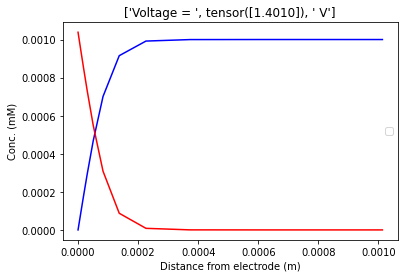

800 tensor([1.4010])
tensor([1.4020]) 1e-09 1e-09 tensor([6.8349e-14]) tensor([0.0053])
tensor([1.4030]) 1e-09 1e-09 tensor([6.5738e-14]) tensor([0.0053])
tensor([1.4040]) 1e-09 1e-09 tensor([6.3232e-14]) tensor([0.0052])
tensor([1.4050]) 1e-09 1e-09 tensor([6.0820e-14]) tensor([0.0052])
tensor([1.4060]) 1e-09 1e-09 tensor([5.8507e-14]) tensor([0.0052])
tensor([1.4070]) 1e-09 1e-09 tensor([5.6268e-14]) tensor([0.0052])
tensor([1.4080]) 1e-09 1e-09 tensor([5.4125e-14]) tensor([0.0052])
tensor([1.4090]) 1e-09 1e-09 tensor([5.2053e-14]) tensor([0.0052])
tensor([1.4100]) 1e-09 1e-09 tensor([5.0068e-14]) tensor([0.0052])
tensor([1.4110]) 1e-09 1e-09 tensor([4.8156e-14]) tensor([0.0052])
tensor([1.4120]) 1e-09 1e-09 tensor([4.6318e-14]) tensor([0.0052])
tensor([1.4130]) 1e-09 1e-09 tensor([4.4546e-14]) tensor([0.0052])
tensor([1.4140]) 1e-09 1e-09 tensor([4.2848e-14]) tensor([0.0052])
tensor([1.4150]) 1e-09 1e-09 tensor([4.1211e-14]) tensor([0.0052])
tensor([1.4160]) 1e-09 1e-09 tensor([3.96

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


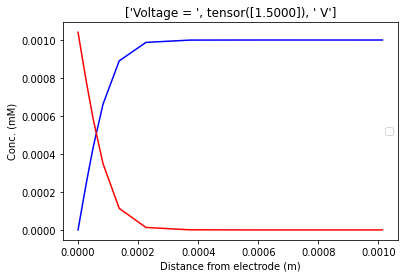

900 tensor([1.5000])
tensor([1.4990]) 1e-09 1e-09 tensor([1.5677e-15]) tensor([0.0049])
tensor([1.4980]) 1e-09 1e-09 tensor([1.6299e-15]) tensor([0.0049])
tensor([1.4970]) 1e-09 1e-09 tensor([1.6946e-15]) tensor([0.0049])
tensor([1.4960]) 1e-09 1e-09 tensor([1.7620e-15]) tensor([0.0049])
tensor([1.4950]) 1e-09 1e-09 tensor([1.8322e-15]) tensor([0.0048])
tensor([1.4940]) 1e-09 1e-09 tensor([1.9050e-15]) tensor([0.0048])
tensor([1.4930]) 1e-09 1e-09 tensor([1.9807e-15]) tensor([0.0048])
tensor([1.4920]) 1e-09 1e-09 tensor([2.0594e-15]) tensor([0.0048])
tensor([1.4910]) 1e-09 1e-09 tensor([2.1411e-15]) tensor([0.0048])
tensor([1.4900]) 1e-09 1e-09 tensor([2.2260e-15]) tensor([0.0048])
tensor([1.4890]) 1e-09 1e-09 tensor([2.3147e-15]) tensor([0.0048])
tensor([1.4880]) 1e-09 1e-09 tensor([2.4067e-15]) tensor([0.0048])
tensor([1.4870]) 1e-09 1e-09 tensor([2.5023e-15]) tensor([0.0048])
tensor([1.4860]) 1e-09 1e-09 tensor([2.6016e-15]) tensor([0.0048])
tensor([1.4850]) 1e-09 1e-09 tensor([2.70

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


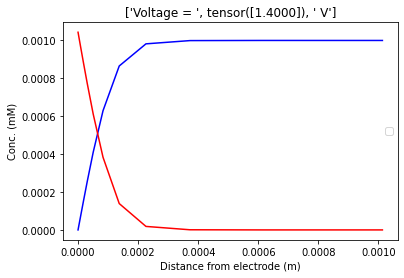

1000 tensor([1.4000])
tensor([1.3990]) 1e-09 1e-09 tensor([7.7195e-14]) tensor([0.0045])
tensor([1.3980]) 1e-09 1e-09 tensor([8.0259e-14]) tensor([0.0045])
tensor([1.3970]) 1e-09 1e-09 tensor([8.3441e-14]) tensor([0.0045])
tensor([1.3960]) 1e-09 1e-09 tensor([8.6752e-14]) tensor([0.0045])
tensor([1.3950]) 1e-09 1e-09 tensor([9.0199e-14]) tensor([0.0045])
tensor([1.3940]) 1e-09 1e-09 tensor([9.3787e-14]) tensor([0.0045])
tensor([1.3930]) 1e-09 1e-09 tensor([9.7516e-14]) tensor([0.0045])
tensor([1.3920]) 1e-09 1e-09 tensor([1.0139e-13]) tensor([0.0045])
tensor([1.3910]) 1e-09 1e-09 tensor([1.0541e-13]) tensor([0.0045])
tensor([1.3900]) 1e-09 1e-09 tensor([1.0960e-13]) tensor([0.0045])
tensor([1.3890]) 1e-09 1e-09 tensor([1.1395e-13]) tensor([0.0045])
tensor([1.3880]) 1e-09 1e-09 tensor([1.1849e-13]) tensor([0.0045])
tensor([1.3870]) 1e-09 1e-09 tensor([1.2320e-13]) tensor([0.0045])
tensor([1.3860]) 1e-09 1e-09 tensor([1.2810e-13]) tensor([0.0045])
tensor([1.3850]) 1e-09 1e-09 tensor([1.3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


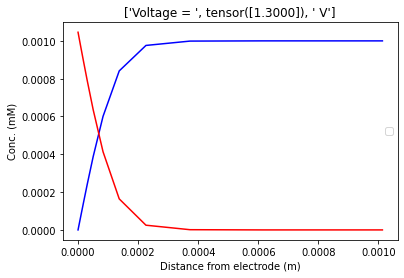

1100 tensor([1.3000])
tensor([1.2990]) 1e-09 1e-09 tensor([3.8003e-12]) tensor([0.0043])
tensor([1.2980]) 1e-09 1e-09 tensor([3.9511e-12]) tensor([0.0043])
tensor([1.2970]) 1e-09 1e-09 tensor([4.1081e-12]) tensor([0.0043])
tensor([1.2960]) 1e-09 1e-09 tensor([4.2711e-12]) tensor([0.0043])
tensor([1.2950]) 1e-09 1e-09 tensor([4.4411e-12]) tensor([0.0043])
tensor([1.2940]) 1e-09 1e-09 tensor([4.6177e-12]) tensor([0.0043])
tensor([1.2930]) 1e-09 1e-09 tensor([4.8012e-12]) tensor([0.0043])
tensor([1.2920]) 1e-09 1e-09 tensor([4.9920e-12]) tensor([0.0043])
tensor([1.2910]) 1e-09 1e-09 tensor([5.1901e-12]) tensor([0.0043])
tensor([1.2900]) 1e-09 1e-09 tensor([5.3964e-12]) tensor([0.0043])
tensor([1.2890]) 1e-09 1e-09 tensor([5.6108e-12]) tensor([0.0043])
tensor([1.2880]) 1e-09 1e-09 tensor([5.8336e-12]) tensor([0.0043])
tensor([1.2870]) 1e-09 1e-09 tensor([6.0654e-12]) tensor([0.0043])
tensor([1.2860]) 1e-09 1e-09 tensor([6.3063e-12]) tensor([0.0043])
tensor([1.2850]) 1e-09 1e-09 tensor([6.5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


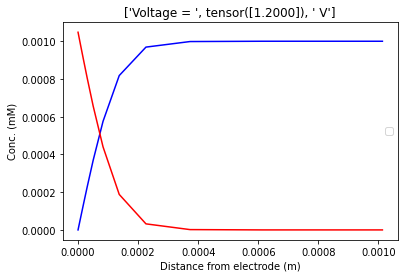

1200 tensor([1.2000])
tensor([1.1990]) 1e-09 1e-09 tensor([1.8708e-10]) tensor([0.0041])
tensor([1.1980]) 1e-09 1e-09 tensor([1.9452e-10]) tensor([0.0041])
tensor([1.1970]) 1e-09 1e-09 tensor([2.0225e-10]) tensor([0.0041])
tensor([1.1960]) 1e-09 1e-09 tensor([2.1028e-10]) tensor([0.0041])
tensor([1.1950]) 1e-09 1e-09 tensor([2.1865e-10]) tensor([0.0041])
tensor([1.1940]) 1e-09 1e-09 tensor([2.2731e-10]) tensor([0.0041])
tensor([1.1930]) 1e-09 1e-09 tensor([2.3636e-10]) tensor([0.0041])
tensor([1.1920]) 1e-09 1e-09 tensor([2.4575e-10]) tensor([0.0040])
tensor([1.1910]) 1e-09 1e-09 tensor([2.5552e-10]) tensor([0.0040])
tensor([1.1900]) 1e-09 1e-09 tensor([2.6566e-10]) tensor([0.0040])
tensor([1.1890]) 1e-09 1e-09 tensor([2.7622e-10]) tensor([0.0040])
tensor([1.1880]) 1e-09 1e-09 tensor([2.8720e-10]) tensor([0.0040])
tensor([1.1870]) 1e-09 1e-09 tensor([2.9860e-10]) tensor([0.0040])
tensor([1.1860]) 1e-09 1e-09 tensor([3.1045e-10]) tensor([0.0040])
tensor([1.1850]) 1e-09 1e-09 tensor([3.2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


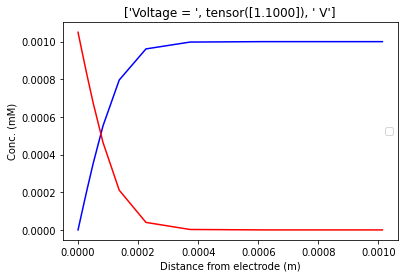

1300 tensor([1.1000])
tensor([1.0990]) 1e-09 1e-09 tensor([9.2089e-09]) tensor([0.0039])
tensor([1.0980]) 1e-09 1e-09 tensor([9.5751e-09]) tensor([0.0039])
tensor([1.0970]) 1e-09 1e-09 tensor([9.9549e-09]) tensor([0.0039])
tensor([1.0960]) 1e-09 1e-09 tensor([1.0351e-08]) tensor([0.0039])
tensor([1.0950]) 1e-09 1e-09 tensor([1.0762e-08]) tensor([0.0039])
tensor([1.0940]) 1e-09 1e-09 tensor([1.1189e-08]) tensor([0.0039])
tensor([1.0930]) 1e-09 1e-09 tensor([1.1635e-08]) tensor([0.0039])
tensor([1.0920]) 1e-09 1e-09 tensor([1.2098e-08]) tensor([0.0039])
tensor([1.0910]) 1e-09 1e-09 tensor([1.2579e-08]) tensor([0.0039])
tensor([1.0900]) 1e-09 1e-09 tensor([1.3078e-08]) tensor([0.0039])
tensor([1.0890]) 1e-09 1e-09 tensor([1.3597e-08]) tensor([0.0039])
tensor([1.0880]) 1e-09 1e-09 tensor([1.4138e-08]) tensor([0.0039])
tensor([1.0870]) 1e-09 1e-09 tensor([1.4701e-08]) tensor([0.0039])
tensor([1.0860]) 1e-09 1e-09 tensor([1.5284e-08]) tensor([0.0039])
tensor([1.0850]) 1e-09 1e-09 tensor([1.5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


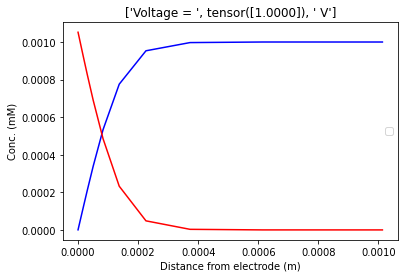

1400 tensor([1.0000])
tensor([0.9990]) 1e-09 1e-09 tensor([4.5321e-07]) tensor([0.0037])
tensor([0.9980]) 1e-09 1e-09 tensor([4.7114e-07]) tensor([0.0037])
tensor([0.9970]) 1e-09 1e-09 tensor([4.8980e-07]) tensor([0.0037])
tensor([0.9960]) 1e-09 1e-09 tensor([5.0925e-07]) tensor([0.0037])
tensor([0.9950]) 1e-09 1e-09 tensor([5.2940e-07]) tensor([0.0037])
tensor([0.9940]) 1e-09 1e-09 tensor([5.5045e-07]) tensor([0.0037])
tensor([0.9930]) 1e-09 1e-09 tensor([5.7231e-07]) tensor([0.0037])
tensor([0.9920]) 1e-09 1e-09 tensor([5.9496e-07]) tensor([0.0037])
tensor([0.9910]) 1e-09 1e-09 tensor([6.1856e-07]) tensor([0.0037])
tensor([0.9900]) 1e-09 1e-09 tensor([6.4311e-07]) tensor([0.0037])
tensor([0.9890]) 1e-09 1e-09 tensor([6.6865e-07]) tensor([0.0037])
tensor([0.9880]) 1e-09 1e-09 tensor([6.9525e-07]) tensor([0.0037])
tensor([0.9870]) 1e-09 1e-09 tensor([7.2286e-07]) tensor([0.0037])
tensor([0.9860]) 1e-09 1e-09 tensor([7.5159e-07]) tensor([0.0037])
tensor([0.9850]) 1e-09 1e-09 tensor([7.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


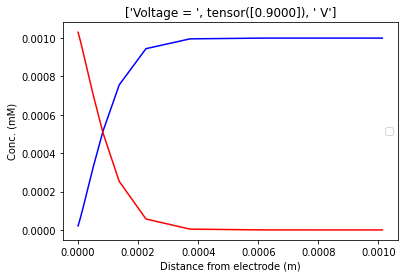

1500 tensor([0.9000])
tensor([0.8990]) 1e-09 1e-09 tensor([2.1800e-05]) tensor([0.0026])
tensor([0.8980]) 1e-09 1e-09 tensor([2.2623e-05]) tensor([0.0026])
tensor([0.8970]) 1e-09 1e-09 tensor([2.3482e-05]) tensor([0.0025])
tensor([0.8960]) 1e-09 1e-09 tensor([2.4398e-05]) tensor([0.0025])
tensor([0.8950]) 1e-09 1e-09 tensor([2.5369e-05]) tensor([0.0024])
tensor([0.8940]) 1e-09 1e-09 tensor([2.6364e-05]) tensor([0.0024])
tensor([0.8930]) 1e-09 1e-09 tensor([2.7382e-05]) tensor([0.0024])
tensor([0.8920]) 1e-09 1e-09 tensor([2.8440e-05]) tensor([0.0023])
tensor([0.8910]) 1e-09 1e-09 tensor([2.9569e-05]) tensor([0.0023])
tensor([0.8900]) 1e-09 1e-09 tensor([3.0684e-05]) tensor([0.0022])
tensor([0.8890]) 1e-09 1e-09 tensor([3.1878e-05]) tensor([0.0022])
tensor([0.8880]) 1e-09 1e-09 tensor([3.3082e-05]) tensor([0.0021])
tensor([0.8870]) 1e-09 1e-09 tensor([3.4374e-05]) tensor([0.0020])
tensor([0.8860]) 1e-09 1e-09 tensor([3.5660e-05]) tensor([0.0020])
tensor([0.8850]) 1e-09 1e-09 tensor([3.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


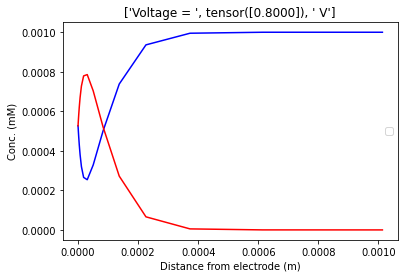

1600 tensor([0.8000])
tensor([0.7990]) 1e-09 1e-09 tensor([0.0005]) tensor([-0.0145])
tensor([0.7980]) 1e-09 1e-09 tensor([0.0005]) tensor([-0.0148])
tensor([0.7970]) 1e-09 1e-09 tensor([0.0006]) tensor([-0.0150])
tensor([0.7960]) 1e-09 1e-09 tensor([0.0006]) tensor([-0.0152])
tensor([0.7950]) 1e-09 1e-09 tensor([0.0006]) tensor([-0.0154])
tensor([0.7940]) 1e-09 1e-09 tensor([0.0006]) tensor([-0.0155])
tensor([0.7930]) 1e-09 1e-09 tensor([0.0006]) tensor([-0.0157])
tensor([0.7920]) 1e-09 1e-09 tensor([0.0006]) tensor([-0.0158])
tensor([0.7910]) 1e-09 1e-09 tensor([0.0006]) tensor([-0.0160])
tensor([0.7900]) 1e-09 1e-09 tensor([0.0006]) tensor([-0.0163])
tensor([0.7890]) 1e-09 1e-09 tensor([0.0006]) tensor([-0.0164])
tensor([0.7880]) 1e-09 1e-09 tensor([0.0006]) tensor([-0.0165])
tensor([0.7870]) 1e-09 1e-09 tensor([0.0007]) tensor([-0.0167])
tensor([0.7860]) 1e-09 1e-09 tensor([0.0007]) tensor([-0.0168])
tensor([0.7850]) 1e-09 1e-09 tensor([0.0007]) tensor([-0.0168])
tensor([0.7840]) 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


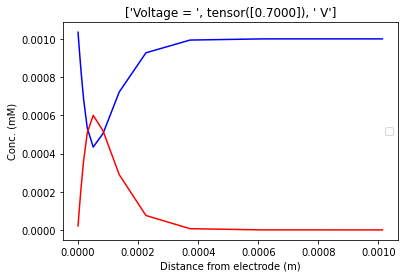

1700 tensor([0.7000])
tensor([0.6990]) 1e-09 1e-09 tensor([0.0010]) tensor([-0.0114])
tensor([0.6980]) 1e-09 1e-09 tensor([0.0010]) tensor([-0.0112])
tensor([0.6970]) 1e-09 1e-09 tensor([0.0010]) tensor([-0.0110])
tensor([0.6960]) 1e-09 1e-09 tensor([0.0010]) tensor([-0.0110])
tensor([0.6950]) 1e-09 1e-09 tensor([0.0010]) tensor([-0.0110])
tensor([0.6940]) 1e-09 1e-09 tensor([0.0010]) tensor([-0.0108])
tensor([0.6930]) 1e-09 1e-09 tensor([0.0010]) tensor([-0.0106])
tensor([0.6920]) 1e-09 1e-09 tensor([0.0010]) tensor([-0.0106])
tensor([0.6910]) 1e-09 1e-09 tensor([0.0010]) tensor([-0.0106])
tensor([0.6900]) 1e-09 1e-09 tensor([0.0010]) tensor([-0.0104])
tensor([0.6890]) 1e-09 1e-09 tensor([0.0010]) tensor([-0.0104])
tensor([0.6880]) 1e-09 1e-09 tensor([0.0010]) tensor([-0.0104])
tensor([0.6870]) 1e-09 1e-09 tensor([0.0010]) tensor([-0.0102])
tensor([0.6860]) 1e-09 1e-09 tensor([0.0010]) tensor([-0.0102])
tensor([0.6850]) 1e-09 1e-09 tensor([0.0010]) tensor([-0.0100])
tensor([0.6840]) 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


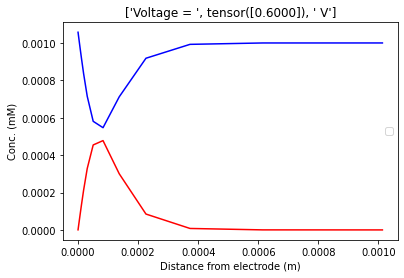

1800 tensor([0.6000])
tensor([0.5990]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0063])
tensor([0.5980]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0063])
tensor([0.5970]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0063])
tensor([0.5960]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0063])
tensor([0.5950]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0063])
tensor([0.5940]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0063])
tensor([0.5930]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0061])
tensor([0.5920]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0063])
tensor([0.5910]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0061])
tensor([0.5900]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0061])
tensor([0.5890]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0061])
tensor([0.5880]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0061])
tensor([0.5870]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0061])
tensor([0.5860]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0061])
tensor([0.5850]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0061])
tensor([0.5840]) 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


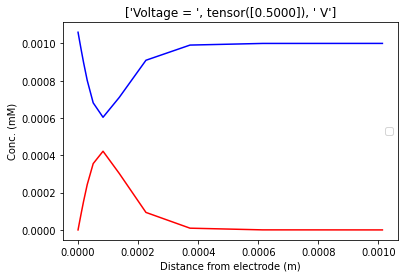

1900 tensor([0.5000])
tensor([0.4990]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0047])
tensor([0.4980]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0047])
tensor([0.4970]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0045])
tensor([0.4960]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0045])
tensor([0.4950]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0047])
tensor([0.4940]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0045])
tensor([0.4930]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0045])
tensor([0.4920]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0045])
tensor([0.4910]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0045])
tensor([0.4900]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0045])
tensor([0.4890]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0045])
tensor([0.4880]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0045])
tensor([0.4870]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0045])
tensor([0.4860]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0045])
tensor([0.4850]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0043])
tensor([0.4840]) 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


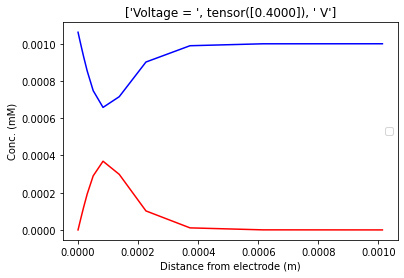

2000 tensor([0.4000])
tensor([0.3990]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0035])
tensor([0.3980]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0037])
tensor([0.3970]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0035])
tensor([0.3960]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0035])
tensor([0.3950]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0035])
tensor([0.3940]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0035])
tensor([0.3930]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0035])
tensor([0.3920]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0035])
tensor([0.3910]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0035])
tensor([0.3900]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0035])
tensor([0.3890]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0037])
tensor([0.3880]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0035])
tensor([0.3870]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0035])
tensor([0.3860]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0035])
tensor([0.3850]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0035])
tensor([0.3840]) 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


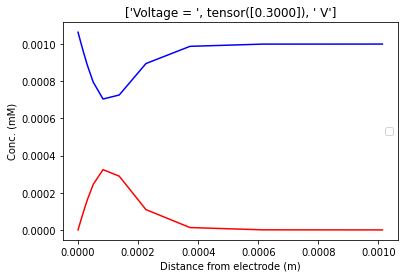

2100 tensor([0.3000])
tensor([0.2990]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0030])
tensor([0.2980]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0028])
tensor([0.2970]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0030])
tensor([0.2960]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0030])
tensor([0.2950]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0028])
tensor([0.2940]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0030])
tensor([0.2930]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0030])
tensor([0.2920]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0028])
tensor([0.2910]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0028])
tensor([0.2900]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0028])
tensor([0.2890]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0028])
tensor([0.2880]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0030])
tensor([0.2870]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0028])
tensor([0.2860]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0028])
tensor([0.2850]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0028])
tensor([0.2840]) 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


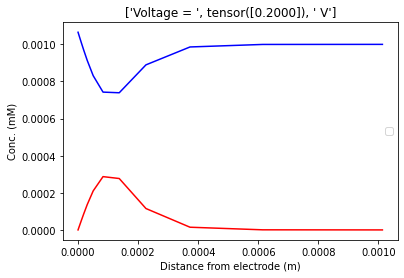

2200 tensor([0.2000])
tensor([0.1990]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0024])
tensor([0.1980]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0024])
tensor([0.1970]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0026])
tensor([0.1960]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0024])
tensor([0.1950]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0024])
tensor([0.1940]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0024])
tensor([0.1930]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0026])
tensor([0.1920]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0024])
tensor([0.1910]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0024])
tensor([0.1900]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0024])
tensor([0.1890]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0024])
tensor([0.1880]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0024])
tensor([0.1870]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0024])
tensor([0.1860]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0022])
tensor([0.1850]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0024])
tensor([0.1840]) 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


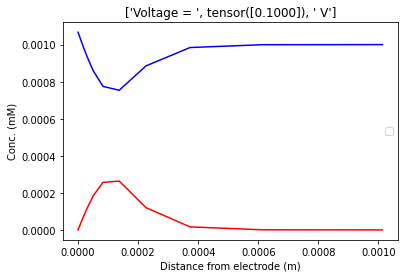

2300 tensor([0.1000])
tensor([0.1000]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0022])
tensor([0.1010]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0022])
tensor([0.1020]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0020])
tensor([0.1030]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0022])
tensor([0.1040]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0022])
tensor([0.1050]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0022])
tensor([0.1060]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0022])
tensor([0.1070]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0020])
tensor([0.1080]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0020])
tensor([0.1090]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0020])
tensor([0.1100]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0020])
tensor([0.1110]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0020])
tensor([0.1120]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0020])
tensor([0.1130]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0020])
tensor([0.1140]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0020])
tensor([0.1150]) 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


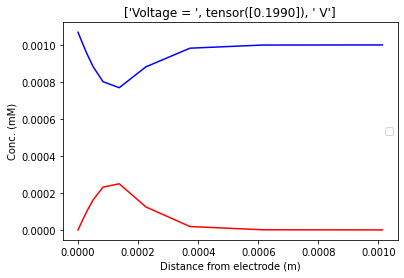

2400 tensor([0.1990])
tensor([0.2000]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0018])
tensor([0.2010]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0018])
tensor([0.2020]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0018])
tensor([0.2030]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0020])
tensor([0.2040]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0018])
tensor([0.2050]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0018])
tensor([0.2060]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0020])
tensor([0.2070]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0018])
tensor([0.2080]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0020])
tensor([0.2090]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0018])
tensor([0.2100]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0020])
tensor([0.2110]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0018])
tensor([0.2120]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0018])
tensor([0.2130]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0018])
tensor([0.2140]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0018])
tensor([0.2150]) 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


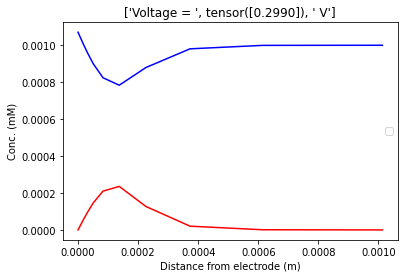

2500 tensor([0.2990])
tensor([0.3000]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.3010]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.3020]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.3030]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.3040]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.3050]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.3060]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0018])
tensor([0.3070]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.3080]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.3090]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0018])
tensor([0.3100]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.3110]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.3120]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.3130]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.3140]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.3150]) 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


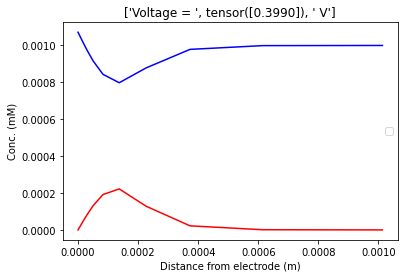

2600 tensor([0.3990])
tensor([0.4000]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.4010]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.4020]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.4030]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.4040]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.4050]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.4060]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.4070]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.4080]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.4090]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.4100]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.4110]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.4120]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.4130]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.4140]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0016])
tensor([0.4150]) 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


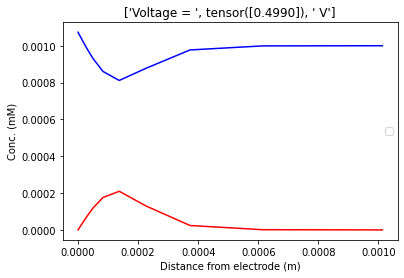

2700 tensor([0.4990])
tensor([0.5000]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.5010]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.5020]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.5030]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.5040]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.5050]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.5060]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0012])
tensor([0.5070]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.5080]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0012])
tensor([0.5090]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.5100]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.5110]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.5120]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.5130]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.5140]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0014])
tensor([0.5150]) 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


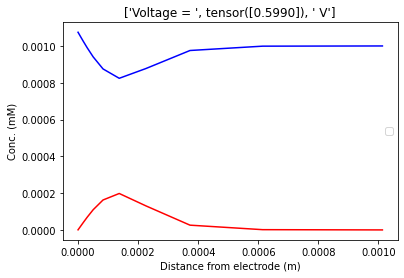

2800 tensor([0.5990])
tensor([0.6000]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0012])
tensor([0.6010]) 1e-09 1e-09 tensor([0.0011]) tensor([-0.0012])


In [ ]:
for E in Evt:
  kef = kf * math.exp((E-E0)*VT) * dx1 / DR
  keb = kb * math.exp(-(E-E0)*VT) * dx1 / DP
  
  #set values for row 0
  Dopt[0, 0] = math.exp(F * (E - E0)/(R * T))
  Dopt[0, N+1] = -1
  for j in range(1, N+1):
    Dopt[0, j] = 0
  for j in range(N+2, 2*N+2):
    Dopt[0, j] = 0

  Cold[0] = 0
  Cold[N] = CR0
  Cold[N+1] = 0
  Cold[2*N+1] = CP0

  Cnew, LU = torch.solve(Cold, Dopt)

  Istor[count,:] = DR*F*(Cnew[1] - Cnew[0])/dx1
  print(E,kf,kb,Cnew[0],Istor[count,:])

  if count % 100 == 0:
         plt.figure(count)
         plt.plot(x[0:(N+1)],Cnew[0:(N+1)],'-b')
         plt.plot(x[(N+1)::],Cnew[(N+1)::],'-r')
         plt.title(['Voltage = ',E,' V'])
         plt.ylabel('Conc. (mM)')
         plt.xlabel('Distance from electrode (m)')
         plt.legend((1,2),('Reactant','Product'),loc=5)
         plt.show()
         print(count,E)
  count = count + 1
  Cold = Cnew

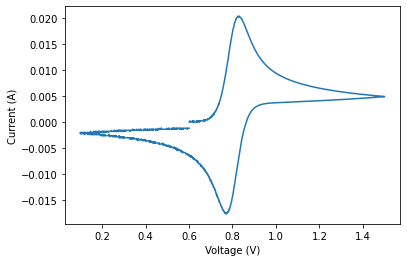

In [ ]:
plt.figure(2)    
plt.plot(Evt,Istor)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.show()


In [ ]:
Cnew_test, LU = torch.solve(Cold, Dopt)
print(torch.dist(Cold.double(), torch.mm(Dopt.double(),Cnew_test.double())))

tensor(0.0025, dtype=torch.float64)


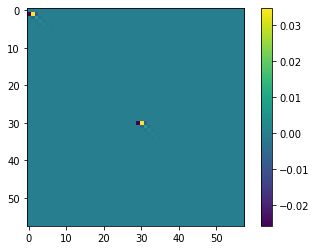

In [ ]:
plt.imshow((Dopt/(1e9)).tolist())
plt.colorbar()

In [ ]:
Evt_tensor = Evt.view(-1)
Istor_tensor = Istor.view(-1)
max_val, max_idx = Istor_tensor.max(0)
min_val, min_idx = Istor_tensor.min(0)
print ('max Evt', Evt_tensor[max_idx], 'max Istor', Istor_tensor[max_idx])
print ('min Evt', Evt_tensor[min_idx], 'min Istor', Istor_tensor[min_idx])

max Evt tensor(0.8310) max Istor tensor(0.0203)
min Evt tensor(0.7720) min Istor tensor(-0.0177)


In [ ]:
dex = (Istor.tolist()).index(max(Istor.tolist()))

print(dex)
print(Evt[dex])
print(Istor[dex])


528
tensor([2.5290])
tensor([2.7851e-07])


In [ ]:

Cnew, LU = torch.solve(Cold, Dopt)


In [ ]:
temp = '1.000000000080179 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.022060807602632432 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -2650314.0114379465 3746766.55123018 -1096451.5397922336 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -853917.3177900391 1518949.7935631552 -665031.4757731161 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -517927.0340992348 921290.0138295691 -403361.9797303343 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -314138.6256752165 558791.03334405 -244651.40766883353 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -190534.70787200908 338924.28756501107 -148388.57969300202 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -115565.14206376355 205568.36519878072 -90002.2231350172 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -70093.8018557187 124683.90962940433 -54589.107773685624 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -42514.03988131567 75625.00743241326 -33109.96755109758 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -25786.068656263604 45869.27911809471 -20082.210461831102 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -15640.041233478823 27821.51759338119 -12180.476359902366 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -9486.1645272747 16874.996889460417 -7387.832362185719 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -5753.649628870504 10235.596465353352 -4480.946836482847 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -3489.7649051541757 6208.596546023355 -2717.831640869179 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -2116.649410165158 3766.09762828941 -1648.4482181242522 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1283.8127631278296 2284.6471483688474 -999.8343852410177 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -778.6718021674212 1386.102011451031 -606.4302092836098 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -472.2883218682312 841.1068367746893 -367.8185149064582 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -286.45734743731083 510.550553938046 -223.09320650073516 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -173.74516392068318 310.05803363698084 -135.31286971629766 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -105.38176889469159 188.45317303132722 -82.07140413663564 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -63.91727380938157 114.69609670391733 -49.778822894535764 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -38.76778625063722 69.96016854057834 -30.192382289941115 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -23.513850970197357 42.82645651881137 -18.312605548614016 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -14.26187154133835 26.36902826579644 -11.107156724458092 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -8.65026235470478 16.38709345032196 -6.736831095617178 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -5.246649332686448 10.332743941483717 -4.08609460879727 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -3.1822536810351596 6.660595339757203 -2.478341658722043 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.9301344245312115 4.4333246257891945 -1.503190201257983 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.1706857058449798 3.0824166502875503 -0.9117309444425705 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.7100567734823054 2.2630495446954804 -0.5529927712131746 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.43067120325364666 1.7660782735938907 -0.33540707034024414 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.2612152890286679 1.4646499606744179 -0.20343467164574994 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.15843508158158418 1.281824447183304 -0.12338936560171967 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.09609573455330316 1.1709351678732374 -0.07483943331993435 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.05828500927418507 1.1036774201382444 -0.04539241086405942 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.035351645126428424 1.0628835340337532 -0.02753188890732487 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.021441856640459535 1.0381407913825542 -0.016698934742094686 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.013005143453601632 1.0231335593592226 -0.010128415905620905 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.007888018238570433 1.0140312130196505 -0.006143194781080177 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.004784324906065409 1.0085103608893773 -0.003726035983311766 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.002901839741555436 1.0051617948046265 -0.0022599550630710966 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.001760054772825956 1.0031307868081514 -0.0013707320353254183 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0010675271824924963 1.0018989181881677 -0.0008313910056751666 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0006474879662583425 1.0011517521014097 -0.0005042641351513086 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.00039272130333066393 1.0006985729618934 -0.0003058516585627437 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.00023819751119235277 1.0004237059194345 -0.00018550840824226408 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0001444740936054051 1.0002569906308387 -0.00011251653723342095 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -2650314.0114379465 3746766.55123018 -1096451.5397922336 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -853917.3177900391 1518949.7935631552 -665031.4757731161 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -517927.0340992348 921290.0138295691 -403361.9797303343 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -314138.6256752165 558791.03334405 -244651.40766883353 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -190534.70787200908 338924.28756501107 -148388.57969300202 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -115565.14206376355 205568.36519878072 -90002.2231350172 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -70093.8018557187 124683.90962940433 -54589.107773685624 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -42514.03988131567 75625.00743241326 -33109.96755109758 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -25786.068656263604 45869.27911809471 -20082.210461831102 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -15640.041233478823 27821.51759338119 -12180.476359902366 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -9486.1645272747 16874.996889460417 -7387.832362185719 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -5753.649628870504 10235.596465353352 -4480.946836482847 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -3489.7649051541757 6208.596546023355 -2717.831640869179 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -2116.649410165158 3766.09762828941 -1648.4482181242522 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1283.8127631278296 2284.6471483688474 -999.8343852410177 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -778.6718021674212 1386.102011451031 -606.4302092836098 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -472.2883218682312 841.1068367746893 -367.8185149064582 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -286.45734743731083 510.550553938046 -223.09320650073516 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -173.74516392068318 310.05803363698084 -135.31286971629766 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -105.38176889469159 188.45317303132722 -82.07140413663564 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -63.91727380938157 114.69609670391733 -49.778822894535764 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -38.76778625063722 69.96016854057834 -30.192382289941115 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -23.513850970197357 42.82645651881137 -18.312605548614016 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -14.26187154133835 26.36902826579644 -11.107156724458092 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -8.65026235470478 16.38709345032196 -6.736831095617178 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -5.246649332686448 10.332743941483717 -4.08609460879727 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -3.1822536810351596 6.660595339757203 -2.478341658722043 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.9301344245312115 4.4333246257891945 -1.503190201257983 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.1706857058449798 3.0824166502875503 -0.9117309444425705 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.7100567734823054 2.2630495446954804 -0.5529927712131746 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.43067120325364666 1.7660782735938907 -0.33540707034024414 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.2612152890286679 1.4646499606744179 -0.20343467164574994 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.15843508158158418 1.281824447183304 -0.12338936560171967 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.09609573455330316 1.1709351678732374 -0.07483943331993435 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.05828500927418507 1.1036774201382444 -0.04539241086405942 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.035351645126428424 1.0628835340337532 -0.02753188890732487 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.021441856640459535 1.0381407913825542 -0.016698934742094686 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.013005143453601632 1.0231335593592226 -0.010128415905620905 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.007888018238570433 1.0140312130196505 -0.006143194781080177 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.004784324906065409 1.0085103608893773 -0.003726035983311766 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.002901839741555436 1.0051617948046265 -0.0022599550630710966 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.001760054772825956 1.0031307868081514 -0.0013707320353254183 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0010675271824924963 1.0018989181881677 -0.0008313910056751666 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0006474879662583425 1.0011517521014097 -0.0005042641351513086 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.00039272130333066393 1.0006985729618934 -0.0003058516585627437 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.00023819751119235277 1.0004237059194345 -0.00018550840824226408 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0001444740936054051 1.0002569906308387 -0.00011251653723342095 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 '


temp = temp.strip().split()
temp = [float(item) for item in temp]
temp = torch.Tensor(temp).view(Dopt.size())

torch.dist(Dopt, temp)

RuntimeError: ignored

In [ ]:
diff = torch.abs(Dopt-temp)

In [ ]:
diff = torch.abs(Dopt-temp)
print(diff.max())

In [ ]:
Dopt[1]

In [ ]:
temp[1]